# 2. Modelling


## To Do

- GridSearch/Random Search for each model: 
- logistic regression
- decision tree  .. .randomforrest, and get feature importance to help refine number of features .. but need lables?
- neural network

- Repeat with PCA components
- Repeat with changes in features
- ?? SMOTE

- Compare across all models
- ?? What are the best evaluation metrics to use? Make sure understand their interpretation

!! NB
- lower gini index is better

## Imports & Utilities

In [1]:
# General stuff
import os
import time

# Import maths related packages
import pandas as pd
import numpy as np
import math

# Import plotting packages
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# Reset to Default
# plt.style.use('default')


In [21]:
# ML Models & Evaluation

from sklearn import model_selection

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


In [3]:
# Function to Display The Model Fit Results

def print_search_results(search, duration):
    print('------- Search Results --------')
    all_search_results = pd.DataFrame(search.cv_results_)
    print(f"Score: {search.best_score_:.4f}. Mean: {np.mean(all_search_results['mean_test_score']):.4f} and STD {np.std(all_search_results['mean_test_score']):.4f}")
    print(f'Search Took: {duration:.2f} seconds')
    print(f"Best Parameters: {search.best_params_}")
    top_n = 10
    print(f"Top {top_n} out of {len(all_search_results)} combinations:")
    display(all_search_results[['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']].sort_values(by='rank_test_score').head(top_n))

In [4]:
# Function to Present the Evaluation Metrics for a Classification Model

def classification_metrics(for_Model, X_test, y_test, y_pred):
    plt.style.use('default')

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Print various metrics
    print(f'Accuracy: {metrics.accuracy_score(y_true=y_test, y_pred=y_pred):.4f}')
    print(f'Precision: {metrics.precision_score(y_true=y_test, y_pred=y_pred, pos_label="yes"):.4f}')
    print(f'Recall: {metrics.recall_score(y_true=y_test, y_pred=y_pred, pos_label="yes"):.4f}')
    print(f'F1 Score {metrics.f1_score(y_true=y_test, y_pred=y_pred, pos_label="yes"):.4f}')
    print(f'Specificity: {tn / (tn + fp):.4f}')
    print(f'Hamming Loss {metrics.hamming_loss(y_true=y_test, y_pred=y_pred):.4f}')


    # Plot Confusion Matrix
    class_labels = for_Model.classes_
    fig, ax = plt.subplots(figsize=(12,4))
    ax.set_title('Confusion Matrix')
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(ax=ax)
    plt.show

    y_probabilities = for_Model.predict_proba(X_test)[:, 1]
    roc_auc_score = metrics.roc_auc_score(y_true=y_test, y_score=y_probabilities)
    print(f'ROC-AUC Score {roc_auc_score:.4f}')
    gini_score = 2 * roc_auc_score - 1
    print(f'Gini Index: {gini_score:.4f}')

    # Plot the ROC curve
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_title('ROC Curve')
    roc_display = RocCurveDisplay.from_estimator(for_Model, X_test, y_test, ax=ax, pos_label="yes")
    plt.show()

    plt.style.use('ggplot')

# Load the Prepared Data

In [5]:
# Load saved dataset
import pickle

with open('xy_data.pickle', 'rb') as file:
    X_train, X_test, y_train, y_test = pickle.load(file)

## Logistic Regression

In [18]:
# Logistic Regression

# Establish a pipeline for a randomised search & get the best fitted model
logreg_pipeline = make_pipeline(
    LogisticRegression(random_state=42)
)
grid_params = {
    'logisticregression__penalty': ['l1', 'l2'],                # L1 or L2 regularisation
    'logisticregression__solver': ['saga', 'liblinear'],        # Saga is a variant of Sag. With L1 or l2. Large dataset. liblinear is for small datasets, binary classifications
    'logisticregression__C': [0.01, 0.1, 1, 5],                 # Strength of regularisation, default is 1, smaller is stronger
    'logisticregression__max_iter': [600],                      # Max 500 iterations seems to be sufficient
    'logisticregression__class_weight': ['balanced']            # Balanced seems to give a better recall & precision
    # 'logisticregression__class_weight': [None, 'balanced'] # Tries to adjust to balance for classes that are imbalanced
}
# scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
          
# Run the search
start_time = time.perf_counter()
# rand_search = RandomizedSearchCV(logreg_pipeline, grid_params, scoring=scoring, cv=5, refit='accuracy')
rand_search = RandomizedSearchCV(logreg_pipeline, grid_params, scoring='accuracy', cv=5)
rand_search.fit(X_train, y_train)
duration = time.perf_counter() - start_time


/opt/anaconda3/envs/ml_v4/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_v4/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_v4/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_v4/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_v4/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_v4/lib/python3.11/site-pack

------- Search Results --------
Score: 0.6357. Mean: 0.6323 and STD 0.0019
Search Took: 83.65 seconds
Best Parameters: {'logisticregression__solver': 'saga', 'logisticregression__penalty': 'l2', 'logisticregression__max_iter': 600, 'logisticregression__class_weight': 'balanced', 'logisticregression__C': 0.01}
Top 10 out of 10 combinations:


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
2,1,0.635660,1.410031,0.008108,"{'logisticregression__solver': 'saga', 'logist..."
3,2,0.634154,9.096009,0.007416,"{'logisticregression__solver': 'saga', 'logist..."
7,3,0.633315,1.249498,0.007497,"{'logisticregression__solver': 'saga', 'logist..."
6,4,0.633093,1.380269,0.007563,"{'logisticregression__solver': 'saga', 'logist..."
8,5,0.632847,0.077674,0.007233,"{'logisticregression__solver': 'liblinear', 'l..."
4,6,0.632032,0.408056,0.007308,"{'logisticregression__solver': 'liblinear', 'l..."
5,6,0.632032,0.081830,0.007295,"{'logisticregression__solver': 'liblinear', 'l..."
0,8,0.631218,0.086676,0.008296,"{'logisticregression__solver': 'liblinear', 'l..."
1,9,0.630725,0.153503,0.007510,"{'logisticregression__solver': 'liblinear', 'l..."
9,10,0.628356,2.379170,0.007490,"{'logisticregression__solver': 'saga', 'logist..."


Accuracy: 0.6354
Precision: 0.3071
Recall: 0.7136
F1 Score 0.4294
Specificity: 0.6168
Hamming Loss 0.3646
ROC-AUC Score 0.7218
Gini Index: 0.4436


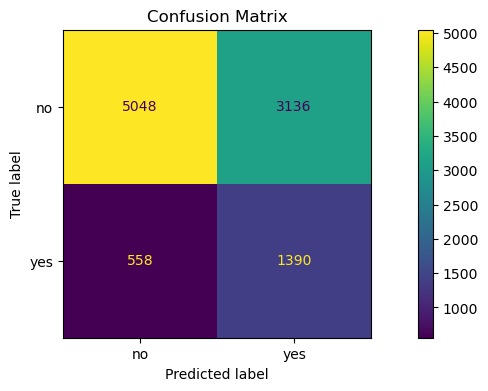

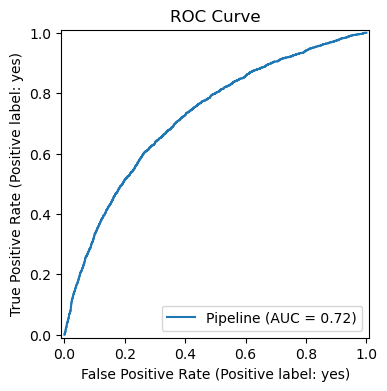

In [19]:
# Show the results
print_search_results(rand_search, duration)

# Get the Best Model & Calculate Predicted Y and Evaluate
model_logreg_rand = rand_search.best_estimator_
y_pred = model_logreg_rand.predict(X_test)
classification_metrics(model_logreg_rand, X_test, y_test, y_pred)

## Decision Tree

In [28]:
# Decision Tree

# Establish a pipeline for a grid search & get the best fitted model
randforest_pipeline = make_pipeline(
    RandomForestClassifier(random_state=42)
)
grid_params = {
    'randomforestclassifier__n_estimators': [200, 400],            # Number of trees
    'randomforestclassifier__max_depth': [25, 50],
    'randomforestclassifier__max_leaf_nodes': [5, 50],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__class_weight': ['balanced']    # Gives more importance to minority classes ... ?? Improves recall at the expense of precision
}                       

# Run the search
start_time = time.perf_counter()
grid_search = GridSearchCV(randforest_pipeline, grid_params, cv=5)
grid_search.fit(X_train, y_train)
duration = time.perf_counter() - start_time

------- Search Results --------
Score: 0.6949. Mean: 0.6758 and STD 0.0189
Search Took: 157.41 seconds
Best Parameters: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 25, 'randomforestclassifier__max_leaf_nodes': 50, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 200}
Top 10 out of 16 combinations:


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
6,1,0.694927,1.610127,0.069530,{'randomforestclassifier__class_weight': 'bala...
14,2,0.694853,1.613818,0.068393,{'randomforestclassifier__class_weight': 'bala...
7,3,0.694829,3.193037,0.131474,{'randomforestclassifier__class_weight': 'bala...
12,4,0.694779,1.644424,0.068930,{'randomforestclassifier__class_weight': 'bala...
4,5,0.694705,1.624854,0.071549,{'randomforestclassifier__class_weight': 'bala...
15,6,0.694582,3.203342,0.132649,{'randomforestclassifier__class_weight': 'bala...
13,7,0.694335,3.206678,0.133604,{'randomforestclassifier__class_weight': 'bala...
5,8,0.694286,3.195969,0.129383,{'randomforestclassifier__class_weight': 'bala...
1,9,0.657472,1.709958,0.087620,{'randomforestclassifier__class_weight': 'bala...
9,9,0.657472,1.720440,0.084255,{'randomforestclassifier__class_weight': 'bala...


Accuracy: 0.6942
Precision: 0.3442
Recall: 0.6520
F1 Score 0.4505
Specificity: 0.7043
Hamming Loss 0.3058
ROC-AUC Score 0.7397
Gini Index: 0.4794


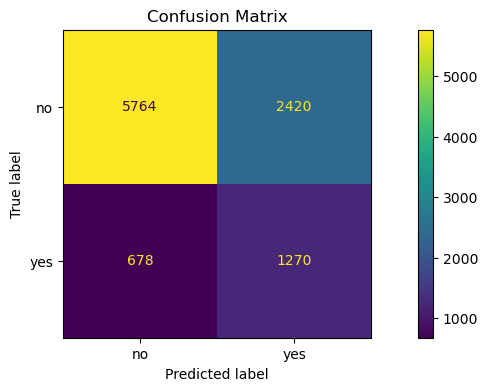

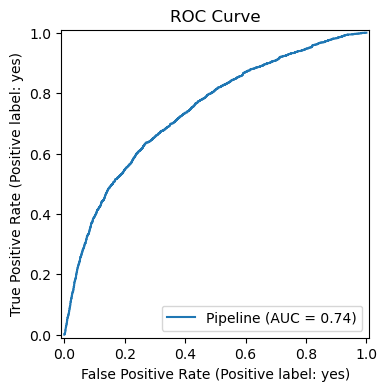

In [29]:
# Show the results
print_search_results(grid_search, duration)

# Get the Best Model & Calculate Predicted Y and Evaluate
model_randforest_grid = grid_search.best_estimator_
y_pred = model_randforest_grid.predict(X_test)
classification_metrics(model_randforest_grid, X_test, y_test, y_pred)